In [1]:
import json
import time
from typing import Dict

from datasets import load_dataset, load_from_disk# type: ignore
from datasets.formatting.formatting import LazyBatch # type: ignore
from huggingface_hub import list_datasets # type: ignore
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style

/Users/nasimeh/anaconda3/envs/npss/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Loading the dataset

In [2]:
data = load_from_disk('Merged_Close_feature_sp_date')
data

DatasetDict({
    train: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 222
    })
    validation: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 22
    })
    test: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 24
    })
})

Transforming to pandas data frame

In [3]:

ds_train = data['train']
ds_test = data['test']
ds_val = data['validation']

df_train = pd.DataFrame(ds_train)
df_test = pd.DataFrame(ds_test)
df_val = pd.DataFrame(ds_val)


    

In [115]:
df_train['Close_numeric']=np.nan
df_test['Close_numeric']=np.nan
df_val['Close_numeric']=np.nan
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


In [5]:
print(df_train['Close'][0])

None


In [ ]:
for i in range(0, len(df_train)):
    if df_train['Close'][i] != None:
        df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))

for i in range(0, len(df_test)):
    if df_test['Close'][i] != None:
        df_test['Close_numeric'][i] = float(df_test['Close'][i].replace(',', ''))

for i in range(0, len(df_val)):
    if df_val['Close'][i] != None:
        df_val['Close_numeric'][i] = float(df_val['Close'][i].replace(',', ''))
        
    

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  209 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


Treat missing values

In [120]:
df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
df_test['Close_numeric'].interpolate(method='nearest', inplace=True)
df_val['Close_numeric'].interpolate(method='nearest', inplace=True)
# Other methods: 'polynomial', 'spline', 'quadratic'
#df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2


/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/3083625172.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/3083625172.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [131]:
df_train['Close_numeric'][0]=df_train['Close_numeric'][1]
df_test['Close_numeric'][len(df_test)-1]=df_test['Close_numeric'][len(df_test)-2]
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           22 non-null     datetime64[ns]
 1   Close          21 non-null     object        
 2   hidden_state   22 non-null     object        
 3   Close_numeric  22 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 836.0+ bytes


/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/3428700610.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][0]=df_train['Close_numeric'][1]
/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipyker

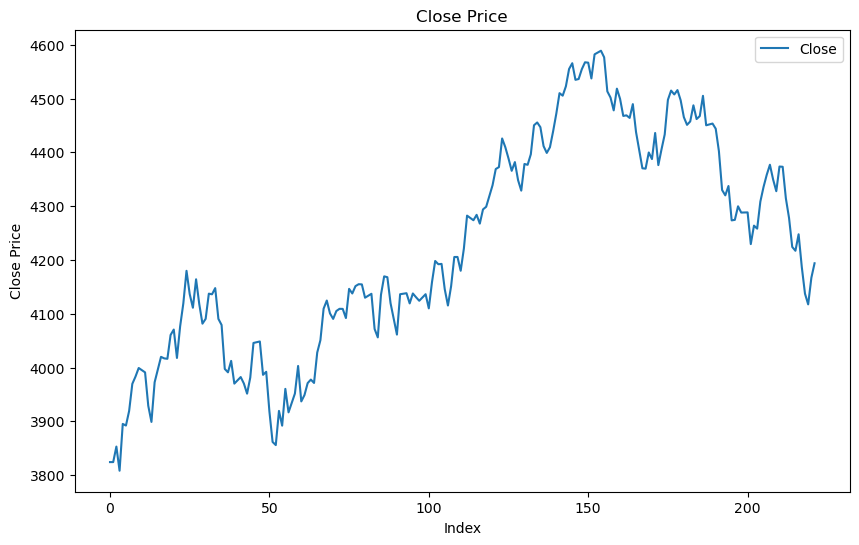

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'], label='Close')

plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


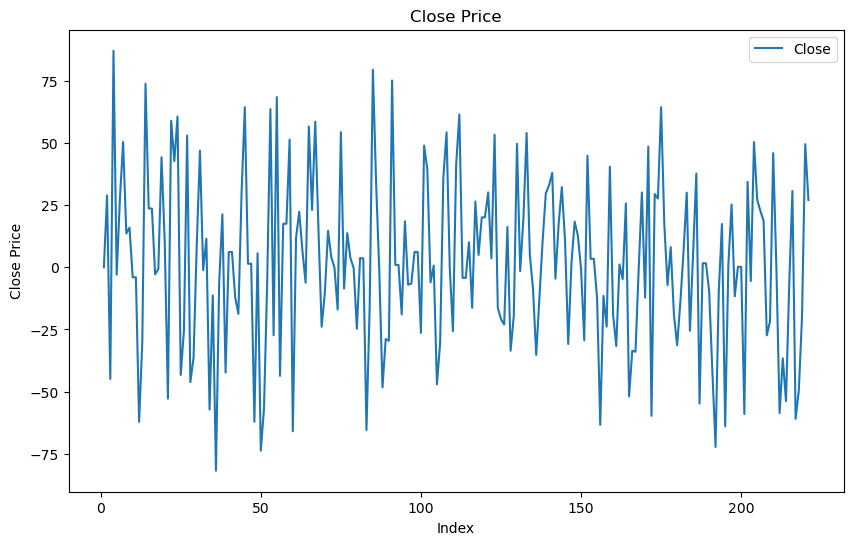

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'].diff(), label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

SARIMA model without exogenous random variable  

In [79]:
import statsmodels.tsa.api as sm

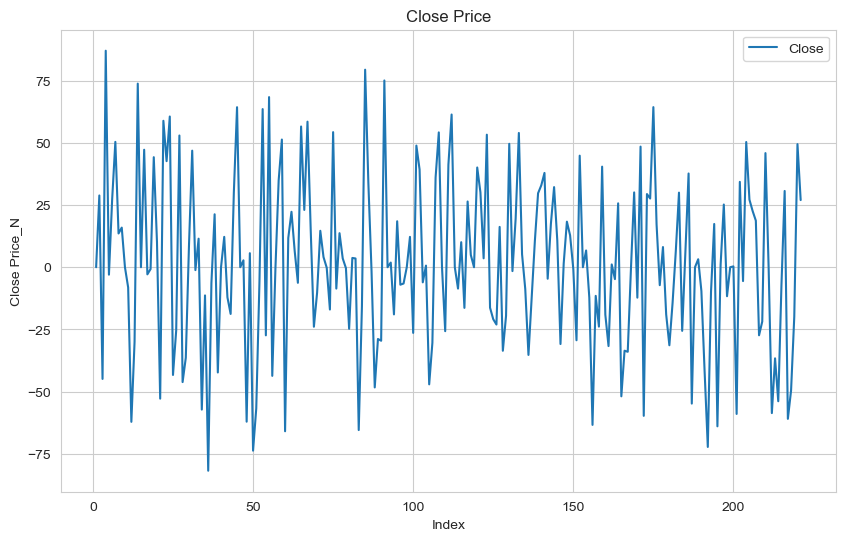

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'].diff(), label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price_N')
plt.legend()
plt.show()

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

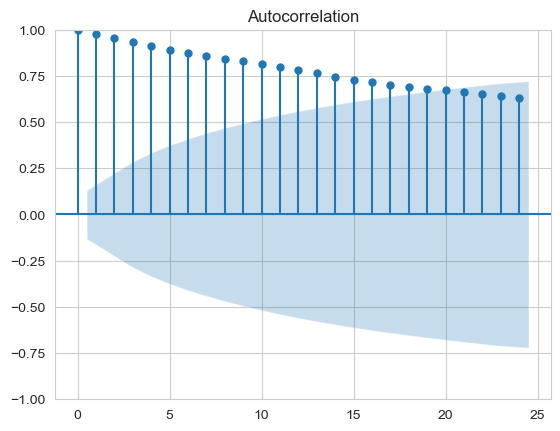

In [83]:
plot_acf(df_train['Close_numeric'].dropna())
plt.show()

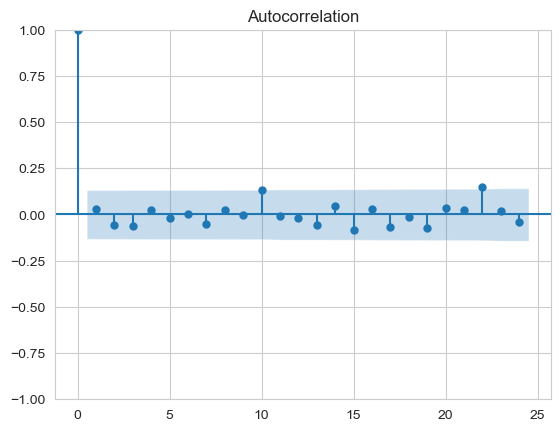

In [82]:
plot_acf(df_train['Close_numeric'].diff().dropna())
plt.show()

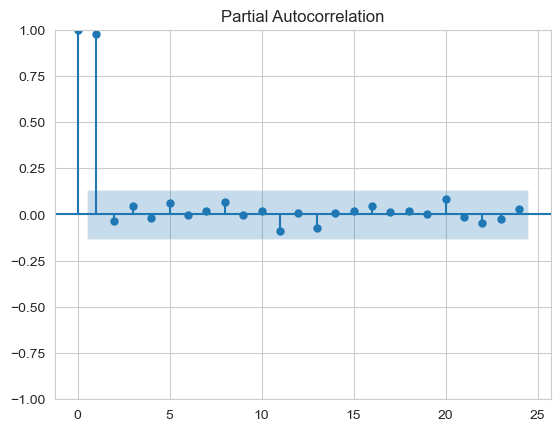

In [86]:
plot_pacf(df_train['Close_numeric'].dropna())
plt.show()

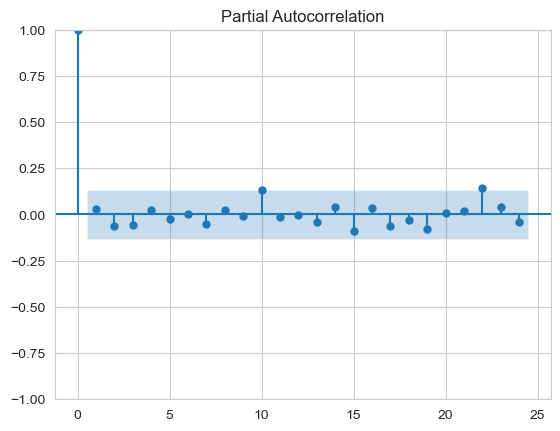

In [87]:
plot_pacf(df_train['Close_numeric'].diff().dropna())
plt.show()

In [89]:
from pmdarima import auto_arima

Train+ Val

In [165]:
df_train_val=pd.concat([df_train, df_val], axis=0, ignore_index=True)


In [166]:
df_diff=df_train_val['Close_numeric'].diff()
df_diff[0]=0
auto_arima(df_train_diff, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2201.125, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2202.936, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2202.911, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2199.653, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2204.779, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.243 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [207]:
auto_arima(df_train_val['Close_numeric'], trace=True, suppress_warnings=True, seasonal=True, m=5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=2414.875, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=2408.225, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=2411.308, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=2411.389, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=2408.180, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=2409.740, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=2409.824, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=2408.712, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=2409.829, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=2409.823, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=2411.821, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 1.172 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

In [359]:
# This is how we fit the model
p=2
d=2
q=0
model = sm.ARIMA(df_train_val['Close_numeric'], order = (p,d,q)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Close_numeric   No. Observations:                  244
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1234.651
Date:                Sun, 26 May 2024   AIC                           2475.303
Time:                        23:17:56   BIC                           2485.770
Sample:                             0   HQIC                          2479.519
                                - 244                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6130      0.066     -9.324      0.000      -0.742      -0.484
ar.L2         -0.2970      0.063     -4.718      0.000      -0.420      -0.174
sigma2      1574.9308    145.005     10.861      0.000    1290.727    1859.135
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.17   Prob(JB):                         0.34
Heteroskedasticity (H):               0.74   Skew:                             0.23
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0, 'Date')

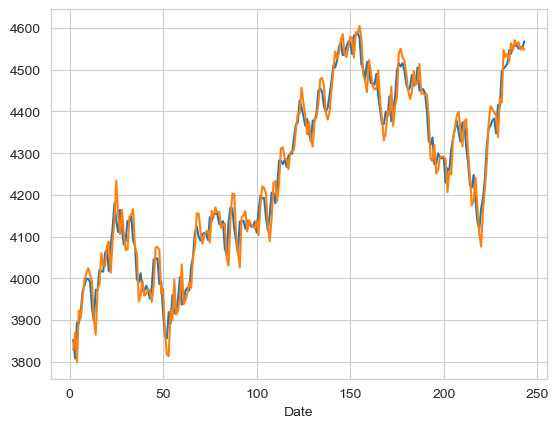

In [360]:
df_train_val['Close_numeric'][p:].plot()
fitted_values = model.fittedvalues
plt.plot(df_train_val.index[p:], fitted_values[p:], label='Fitted Values')
plt.xlabel('Date')


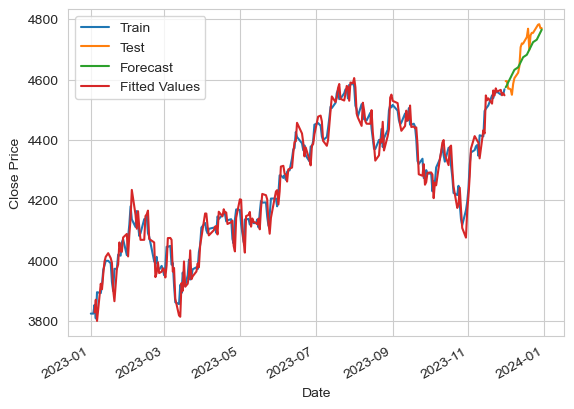

In [361]:
plt.plot(df_train_val['Date'], df_train_val['Close_numeric'], label='Train')
plt.plot(df_test['Date'],df_test['Close_numeric'] , label='Test')
#plt.plot(df_test['Date'], model.forecast(len(df_test)), label='Forecast')
plt.plot(df_test['Date'], model.forecast(len(df_test)), label='Forecast')
plt.plot(df_train_val['Date'][p:], fitted_values[p:], label='Fitted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


<Axes: >

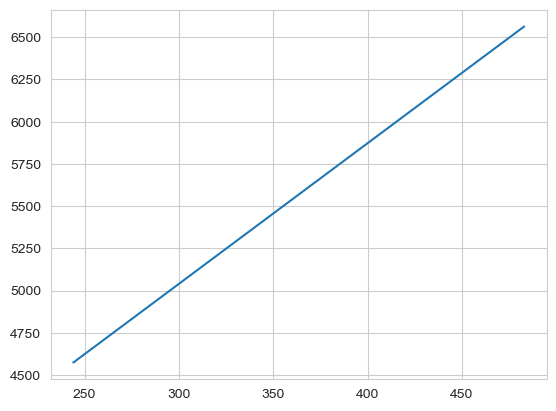

In [362]:
model.forecast(10*len(df_test)).plot()

In [363]:
from sklearn.metrics import mean_squared_error as mse
mse(df_test['Close_numeric'], model.forecast(len(df_test)))

1516.4222168184535

In [374]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

# Example calculation

print('MASE = ', mase(y_train = np.array([1,2,3,4,5]), y_test = np.array([6,7]), y_preds = np.array([3, 3])))


MASE =  2.3333333333333335


In [375]:
print('MASE = ', mase(y_train = df_train_val['Close_numeric'].values, y_test = df_test['Close_numeric'].values, y_preds = model.forecast(len(df_test))))

MASE =  9.093479341505269


In [385]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


Changin the hidden state to numeric

In [ ]:
# Function to convert all entries to float and handle lists
def convert_to_float(value):
    if isinstance(value, list):
        if len(value) == 1:
            return float(value[0])
        else:
            # Handle multi-element lists if necessary (e.g., take mean or sum)
            return float(np.mean(value))
    try:
        return float(value)
    except ValueError:
        return np.nan

# Apply the conversion function to both columns
df_train_val['hidden_state_numeric'] = df_train_val['hidden_state'].apply(convert_to_float)
df_test['hidden_state_numeric'] = df_test['hidden_state'].apply(convert_to_float)


ARIMA model selection with Cross_Validation WITHOUT exogonus variable. 

In [445]:
from sklearn.model_selection import TimeSeriesSplit
import itertools
CV = TimeSeriesSplit(n_splits=30,test_size=1)
mase_dict_wo = {}
mse_dict_wo = {}
p_range = range(0, 5)
d_range = range(0, 3)
q_range = range(0, 5)

for p, d, q in itertools.product(p_range, d_range, q_range):
    mase_list_wo = []
    mse_list_wo = []
    for i, (train_index , test_index) in enumerate(CV.split(df_train_val)):
        df_tt = df_train_val.iloc[train_index]
        df_ho = df_train_val.iloc[test_index]
        # model = sm.ARIMA(df_tt['Close_numeric'], exog=df_tt['hidden_state_numeric'], order = (p,d,q)).fit()
        model = sm.ARIMA(df_tt['Close_numeric'], order = (p,d,q)).fit()
        lag=max(p,q)
        #mase_list.append(mase(y_train = df_tt['Close_numeric'], y_test = df_ho['Close_numeric'], y_preds = model.forecast(len(df_ho),exog=(df_ho['hidden_state_numeric']))))
        mase_list_wo.append(mase(y_train = df_tt['Close_numeric'].values, y_test = df_ho['Close_numeric'].values, y_preds = model.forecast(len(df_ho))))
        #mse_list.append(mse(df_ho['Close_numeric'], model.forecast(len(df_ho),exog=(df_ho['hidden_state_numeric']))))
        mse_list_wo.append(mse(df_ho['Close_numeric'], model.forecast(len(df_ho))))    
    mase_dict_wo[(p,d,q)] = np.mean(mase_list_wo)
    mse_dict_wo[(p,d,q)] = np.mean(mse_list_wo)
    print(f"({p},{d},{q}) done")
    print('MASE = ', mase_dict_wo[(p,d,q)])
    print('MSE = ', mse_dict_wo[(p,d,q)])

min_mase_wo = min(mase_dict_wo, key=mase_dict_wo.get)
print('Min MASE:', min_mase_wo)
min_mse_wo = min(mse_dict_wo, key=mse_dict_wo.get)
print('Min MSE:', min_mse_wo)




(0,0,0) done
MASE =  6.84300055863151
MSE =  46841.916874829614
(0,0,1) done
MASE =  3.8929154666106225
MSE =  15639.571204094927
(0,0,2) done
MASE =  2.3949926888389728
MSE =  6248.627285947672
(0,0,3) done
MASE =  2.0167957348953505
MSE =  4455.011221036013
(0,0,4) done
MASE =  1.9002275766052366
MSE =  3832.510517896736
(0,1,0) done
MASE =  0.9972728997524004
MSE =  1295.2294733333313
(0,1,1) done
MASE =  0.9870574500788326
MSE =  1281.7191308677227
(0,1,2) done
MASE =  1.0039111001011756
MSE =  1314.0914820966605
(0,1,3) done
MASE =  1.0205280507391712
MSE =  1333.336815067628
(0,1,4) done
MASE =  1.0145030676374072
MSE =  1333.8966572097372
(0,2,0) done
MASE =  1.2758002957903072
MSE =  1948.9283066666792
(0,2,1) done
MASE =  0.9770099462560927
MSE =  1275.0232497236332
(0,2,2) done
MASE =  0.9671885272361415
MSE =  1262.8448957547366
(0,2,3) done
MASE =  0.9859206484468553
MSE =  1298.181348711445
(0,2,4) done
MASE =  1.0046715741537733
MSE =  1322.003317529714
(1,0,0) done
MASE 

In [451]:
print(mase_dict_wo[min_mase_wo])
print(np.sqrt(mse_dict_wo[min_mse_wo]))

0.9309569631100926
35.11080890178145


In [450]:
df_train_val['Close_numeric'].diff().std()

34.127003872001424

ARIMA model selection with Cross_Validation WITH exogonus variable. 

In [454]:
from sklearn.model_selection import TimeSeriesSplit
import itertools
CV = TimeSeriesSplit(n_splits=30,test_size=1)
mase_dict = {}
mse_dict = {}
p_range = range(0, 5)
d_range = range(0, 3)
q_range = range(0, 5)

for p, d, q in itertools.product(p_range, d_range, q_range):
    mase_list = []
    mse_list = []
    for i, (train_index , test_index) in enumerate(CV.split(df_train_val)):
        df_tt = df_train_val.iloc[train_index]
        df_ho = df_train_val.iloc[test_index]
        model = sm.ARIMA(df_tt['Close_numeric'], exog=df_tt['hidden_state_numeric'], order = (p,d,q)).fit()
        #model = sm.ARIMA(df_tt['Close_numeric'], order = (p,d,q)).fit()
        lag=max(p,q)
        mase_list.append(mase(y_train = df_tt['Close_numeric'], y_test = df_ho['Close_numeric'], y_preds = model.forecast(len(df_ho),exog=(df_ho['hidden_state_numeric']))))
        #mase_list.append(mase(y_train = df_tt['Close_numeric'].values[lag:], y_test = df_ho['Close_numeric'].values, y_preds = model.forecast(len(df_ho))))
        mse_list.append(mse(df_ho['Close_numeric'], model.forecast(len(df_ho),exog=(df_ho['hidden_state_numeric']))))
        #mse_list.append(mse(df_ho['Close_numeric'], model.forecast(len(df_ho))))    
    mase_dict[(p,d,q)] = np.mean(mase_list)
    mse_dict[(p,d,q)] = np.mean(mse_list)
    print(f"({p},{d},{q}) done")
    print('MASE = ', mase_dict[(p,d,q)])
    print('MSE = ', mse_dict[(p,d,q)])

min_mase = min(mase_dict, key=mase_dict.get)
print('Min MASE:', min_mase)
min_mse = min(mse_dict, key=mse_dict.get)
print('Min MSE:', min_mse)

(0,0,0) done
MASE =  7.001604828660637
MSE =  47310.27487297962
(0,0,1) done
MASE =  4.19897697673463
MSE =  18702.960211214617
(0,0,2) done
MASE =  3.5664643566249703
MSE =  13043.251673130786
(0,0,3) done
MASE =  2.5811855899248046
MSE =  7818.3366768368005
(0,0,4) done
MASE =  2.337156900552083
MSE =  7129.6445891646
(0,1,0) done
MASE =  1.0020128937356483
MSE =  1297.2580296990518
(0,1,1) done
MASE =  0.9915682558552192
MSE =  1283.124332309034
(0,1,2) done
MASE =  1.0084180644918657
MSE =  1315.4746175146804
(0,1,3) done
MASE =  1.0246539890711754
MSE =  1334.7387651763136
(0,1,4) done
MASE =  1.018146099102705
MSE =  1334.5930512018049
(0,2,0) done
MASE =  1.2864509876564323
MSE =  1970.077585708414
(0,2,1) done
MASE =  0.9806177484047951
MSE =  1284.5708304423567
(0,2,2) done
MASE =  0.9720226973007696
MSE =  1272.2367371828448
(0,2,3) done
MASE =  0.9857112491129629
MSE =  1301.970644931059
(0,2,4) done
MASE =  1.0057485238313673
MSE =  1327.654889326505
(1,0,0) done
MASE =  1.

In [455]:
print(mase_dict[min_mase])
print(np.sqrt(mse_dict[min_mse]))

0.9386804715671937
35.01927652771879
